# Imbalanced Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## creating a data set

In [2]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
data = pd.concat([pd.DataFrame(X),pd.DataFrame(y, columns =['y'])], axis =1)
data.head()

,0,1,y
0,0.222014,0.540207,0
1,1.347439,1.412824,0
2,0.537238,0.372730,0
3,2.134462,1.404819,0
4,2.315827,1.356858,0


In [3]:
data[y==1].head()

,0,1,y
207,-1.179816,0.440242,1
649,-0.781657,1.284304,1
843,0.672733,0.629470,1
1017,-1.085901,0.355282,1
1098,-0.811938,1.015700,1


In [4]:
def plot_data(data):
    for label in data['y'].unique():
        row = data[data['y'] == label]
        plt.scatter(row[0], row[1], label=str(label))
    plt.legend()
    plt.show()

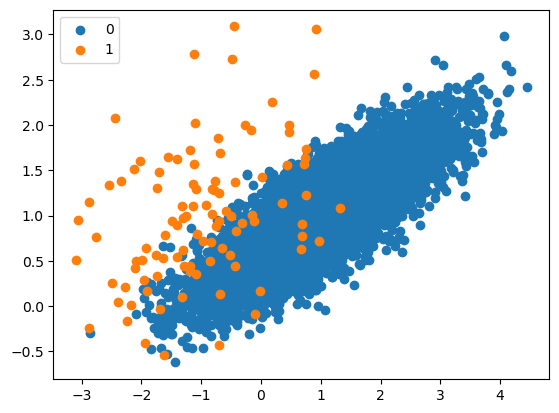

In [5]:
plot_data(data)

## Baseline Methods 

In [6]:
n0 = len(data[data['y']==0])
n1 = len(data[data['y']==1])
print(n0,n1)

9900 100


### Under-sampling
Removing samples from the majority class

y
0    100
1    100
Name: count, dtype: int64


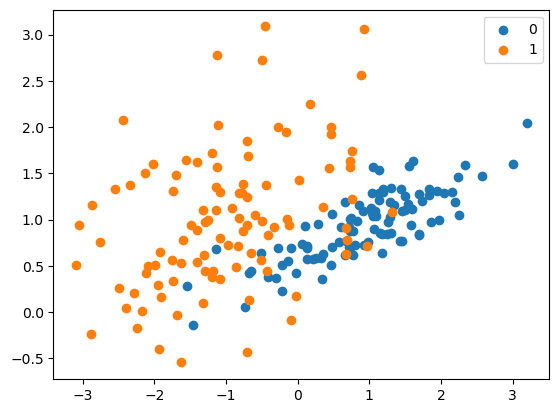

In [7]:
undersampled_data = pd.concat([data[data['y']==0].sample(n1, random_state=1), data[data['y']==1]])
print(undersampled_data['y'].value_counts())
plot_data(undersampled_data)

### Over-sampling
Adding more examples from the minority class.

y
0    9900
1    9900
Name: count, dtype: int64


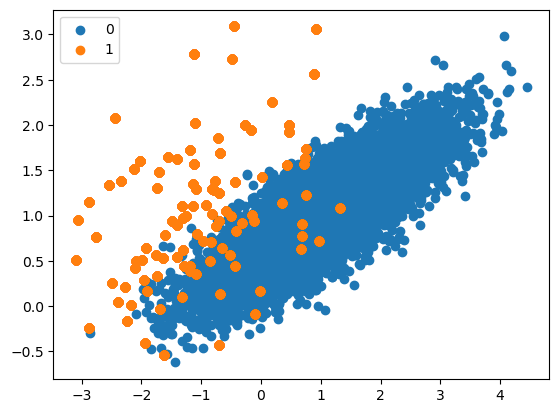

In [8]:
oversampled_data = pd.concat([data[data['y']==0], data[data['y']==1].sample(n0, replace=True, random_state=1)])
print(oversampled_data['y'].value_counts())
plot_data(oversampled_data)

Those methods can balance the class distribution but do not provide any additional information to the model.

## SMOTE
The most widely used approach to synthesizing new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective.

In [9]:
smote_oversample = SMOTE(random_state = 1)
smote_X, smote_y = smote_oversample.fit_resample(X, y)

y
0    9900
1    9900
Name: count, dtype: int64


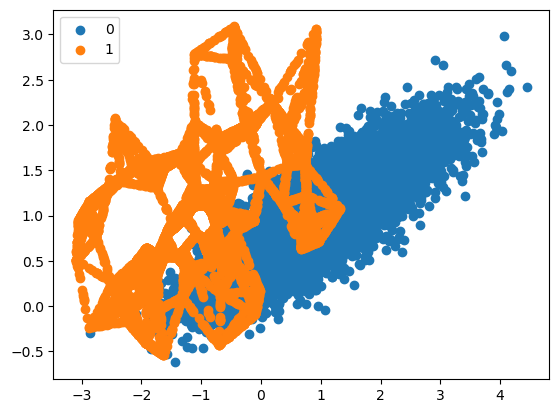

In [10]:
smote_data = pd.concat([pd.DataFrame(smote_X),pd.DataFrame(smote_y, columns =['y'])], axis =1)
print(smote_data['y'].value_counts())
plot_data(smote_data)

#### k_neighbors = 3 (default = 5)

In [11]:
smote_oversample = SMOTE(random_state = 1, k_neighbors = 3)
smote_X, smote_y = smote_oversample.fit_resample(X, y)

y
0    9900
1    9900
Name: count, dtype: int64


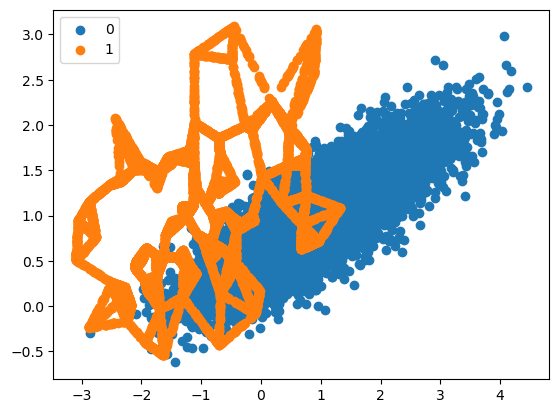

In [12]:
smote_data = pd.concat([pd.DataFrame(smote_X),pd.DataFrame(smote_y, columns =['y'])], axis =1)
print(smote_data['y'].value_counts())
plot_data(smote_data)

The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class.<br>
We can first oversample the minority class using SMOTE, then use random undersampling to reduce the number of examples in the majority class.

y
0    3960
1    1980
Name: count, dtype: int64


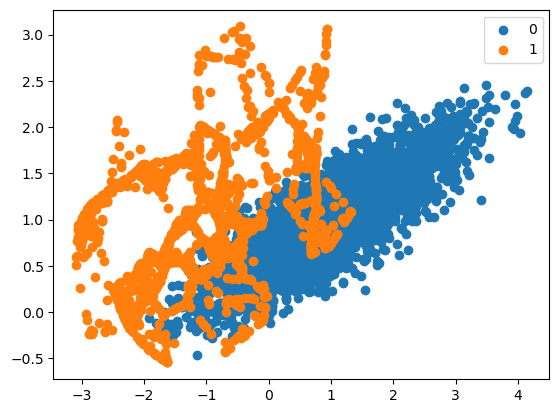

In [13]:
over = SMOTE(sampling_strategy=0.2, random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
smote2_X, smote2_y = pipeline.fit_resample(X, y)
smote2_data = pd.concat([pd.DataFrame(smote2_X),pd.DataFrame(smote2_y, columns =['y'])], axis =1)
print(smote2_data['y'].value_counts())
plot_data(smote2_data)

### SMOTE for Classification

First, let's generate a decision tree classifier on the original dataset.

In [14]:
clf = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f' % np.mean(scores))
scores = cross_val_score(clf, X, y, scoring='recall', cv=cv, n_jobs=-1)
print('Mean recall: %.3f' % np.mean(scores))

Mean ROC AUC: 0.767
Mean Accuracy: 0.990
Mean recall: 0.540


Now, let's use a SMOTE transformed version of the dataset.<br>
When using k-fold cross-validation, the oversampling should be applied on the training dataset only, then evaluate the model on the non-transformed test set.

In [15]:
steps = [('over', SMOTE(random_state=1)), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv)
print('Mean ROC AUC: %.3f' % np.mean(scores))
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f' % np.mean(scores))
scores = cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1)
print('Mean recall: %.3f' % np.mean(scores))

Mean ROC AUC: 0.817
Mean Accuracy: 0.932
Mean recall: 0.693


In [16]:
clf = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.2, random_state=1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
steps = [('over', over), ('under', under), ('model', clf)]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv)
print('Mean ROC AUC: %.3f' % np.mean(scores))
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f' % np.mean(scores))
scores = cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1)
print('Mean recall: %.3f' % np.mean(scores))

Mean ROC AUC: 0.836
Mean Accuracy: 0.944
Mean recall: 0.720


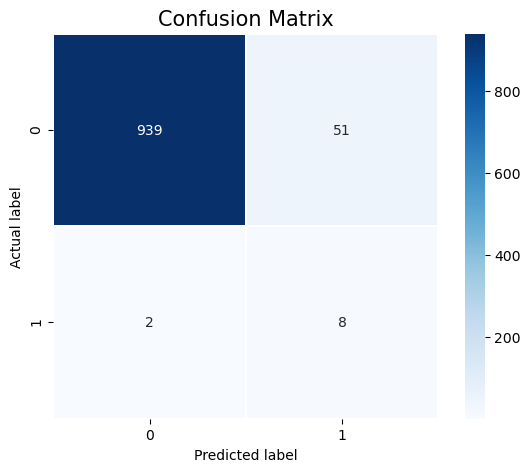

In [17]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
y_pred = np.zeros(y.shape)
for train_index, test_index in cv.split(X, y):
    model = pipeline
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size = 15)
plt.show()


SMOTE use k-nearest neighbors to create the new synthetic examples. <br>
The default is k=5, although larger or smaller values will influence the types of examples created, and may impact the performance of the model.


In [18]:
mean_score = []
for k in range(1,50,2):
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.2, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    model = Pipeline(steps=steps)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
    score = np.mean(scores)
    mean_score.append(score)
    print('k=%d, Mean ROC AUC: %.3f' % (k, score))

k=1, Mean ROC AUC: 0.813
k=3, Mean ROC AUC: 0.812
k=5, Mean ROC AUC: 0.837
k=7, Mean ROC AUC: 0.842
k=9, Mean ROC AUC: 0.854
k=11, Mean ROC AUC: 0.852
k=13, Mean ROC AUC: 0.859
k=15, Mean ROC AUC: 0.859
k=17, Mean ROC AUC: 0.859
k=19, Mean ROC AUC: 0.861
k=21, Mean ROC AUC: 0.848
k=23, Mean ROC AUC: 0.855
k=25, Mean ROC AUC: 0.863
k=27, Mean ROC AUC: 0.857
k=29, Mean ROC AUC: 0.853
k=31, Mean ROC AUC: 0.863
k=33, Mean ROC AUC: 0.856
k=35, Mean ROC AUC: 0.858
k=37, Mean ROC AUC: 0.862
k=39, Mean ROC AUC: 0.870
k=41, Mean ROC AUC: 0.853
k=43, Mean ROC AUC: 0.853
k=45, Mean ROC AUC: 0.877
k=47, Mean ROC AUC: 0.854
k=49, Mean ROC AUC: 0.857


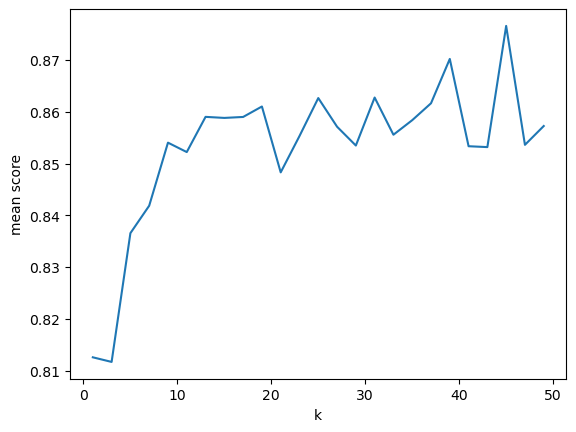

In [19]:
plt.plot(range(1,50,2), mean_score)
plt.xlabel('k')
plt.ylabel('mean score')
plt.show()

y
0    3960
1    1980
Name: count, dtype: int64


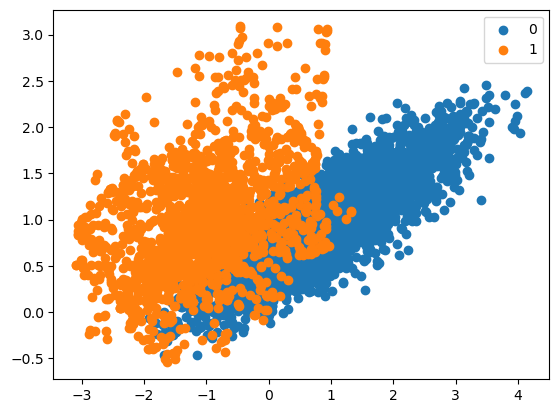

In [20]:
over = SMOTE(sampling_strategy=0.2, random_state = 1, k_neighbors=range(1,50,2)[np.argmax(mean_score)])
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
smote2_X, smote2_y = pipeline.fit_resample(X, y)
smote2_data = pd.concat([pd.DataFrame(smote2_X),pd.DataFrame(smote2_y, columns =['y'])], axis =1)
print(smote2_data['y'].value_counts())
plot_data(smote2_data)

In [21]:

classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(),
}

for classifier_name, classifier in classifiers.items():
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    scores_without_smote = cross_val_score(classifier, X, y, scoring='roc_auc', cv=cv)
    print(f'{classifier_name} Without SMOTE, Mean ROC AUC: %.3f' % np.mean(scores_without_smote))
    
    steps = [('over', SMOTE(random_state=1)), ('model', classifier)]
    pipeline = Pipeline(steps=steps)
    scores_with_smote = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv)
    print(f'{classifier_name} With SMOTE, Mean ROC AUC: %.3f' % np.mean(scores_with_smote))


Decision Tree Without SMOTE, Mean ROC AUC: 0.772
Decision Tree With SMOTE, Mean ROC AUC: 0.805
SVM Without SMOTE, Mean ROC AUC: 0.836
SVM With SMOTE, Mean ROC AUC: 0.954


## Adaptive Synthetic Sampling (ADASYN)
Generating synthetic samples inversely proportional to the density of the examples in the minority class.

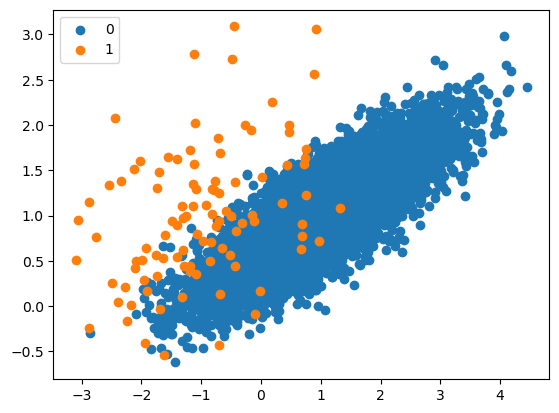

In [22]:
plot_data(data)

y
0    9900
1    9899
Name: count, dtype: int64


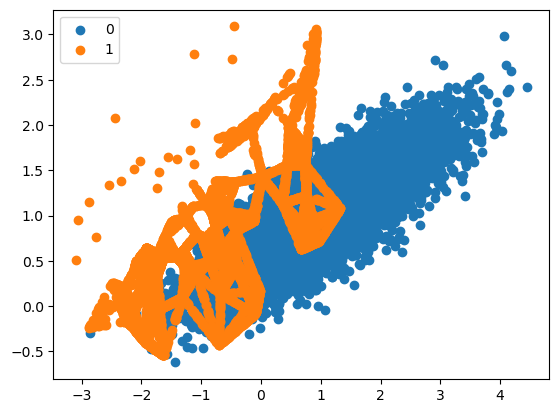

In [23]:
oversample = ADASYN(random_state = 1)
adasyn_X, adasyn_y = oversample.fit_resample(X, y)
adasyn_data = pd.concat([pd.DataFrame(adasyn_X),pd.DataFrame(adasyn_y, columns =['y'])], axis =1)
print(adasyn_data['y'].value_counts())
plot_data(adasyn_data)

y
0    9900
1    9892
Name: count, dtype: int64


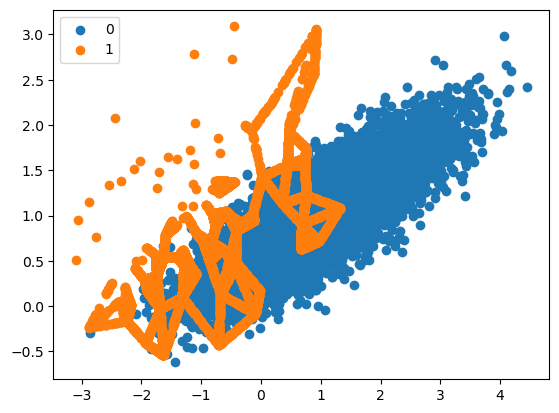

In [24]:
oversample = ADASYN(random_state = 1, n_neighbors = 3)
adasyn_X, adasyn_y = oversample.fit_resample(X, y)
adasyn_data = pd.concat([pd.DataFrame(adasyn_X),pd.DataFrame(adasyn_y, columns =['y'])], axis =1)
print(adasyn_data['y'].value_counts())
plot_data(adasyn_data)

In [25]:
clf = DecisionTreeClassifier()
oversample = ADASYN(random_state = 1)
steps = [('over', oversample),('model', clf)]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.810


In [26]:
param_grid = {
    'over__n_neighbors': [3, 5, 10],
    'model__max_depth': [3, 5, None],
    'model__min_samples_split': [10, 20],
    'model__min_samples_leaf': [5, 10],
}

steps = [('over', ADASYN(random_state = 1)), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X, y)

print('Best parameters:', grid_search.best_params_)
print('Best ROC AUC: %.3f' % grid_search.best_score_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters: {'model__max_depth': 3, 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'over__n_neighbors': 5}
Best ROC AUC: 0.935
